# Vibe Composition Triangle

This notebook categorizes a person as a vampire/werewolf/cowboy depending on responses to the 18 questions listed in function calculate_archetype_percentages_nonlinear. 
It takes as input a csv (or dataframe) containing a column for each of the 18 questions and responses between 1-5, as well as column for "Name".

This notebook produces a ternary plot showing all 16 vibe categorizations and labels, as well as the placement of all respondents in the input dataframe. 

In [46]:
import pandas as pd 
import os
import numpy as np
from shapely import Point, Polygon
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from matplotlib.colors import ListedColormap
import mpltern

project_fldr = r''  # for figure/csv output
df = pd.read_csv(r'')  # df containing appropriate data structure

### Define personality classes and their vertices for plotting and class categorization

In [47]:
personality_classes = {"Pure Vampire": [(70, 0, 30), (100, 0, 0), (70, 30, 0)],
    "Pure Werewolf": [(0, 70, 30), (30, 70, 0), (0, 100, 0)],
    "Pure Cowboy": [(0, 30, 70), (30, 0, 70),(0, 0, 100)],
    "Werewolfy Vampire": [(70, 30, 0), (70, 15, 15), (60, 20, 20), (50, 30, 20), (50, 50, 0)],
    "Cowboy-y Vampire": [(70, 15, 15), (70, 0, 30), (50, 0, 50), (50, 20, 30), (60, 20, 20)],
    "Vampirey Werewolf": [(50, 50, 0), (30, 50, 20), (20, 60, 20), (15, 70, 15), (30, 70, 0)],
    "Vampirey Cowboy": [(30, 20, 50), (50, 0, 50), (30, 0, 70), (15, 15, 70), (20, 20, 60)],
    "Cowboy-y Werewolf": [(15, 70, 15), (20, 60, 20), (20, 50, 30), (0, 50, 50), (0, 70, 30)],
    "Werewolfy Cowboy": [(0, 50, 50), (20, 30, 50), (20, 20, 60), (15, 15, 70), (0, 30, 70)],
    "Hybrid Werewolf/Vampire": [(50, 50, 0), (50, 30, 20), (30, 50, 20)],
    "Hybrid Cowboy/Werewolf": [(20, 50, 30), (20, 30, 50), (0, 50, 50)],
    "Hybrid Vampire/Cowboy": [(50, 20, 30), (50, 0, 50), (30, 20, 50)],
    "Vampirey Hybrid": [(60, 20, 20), (45, 20, 35), (35, 30, 35), (40, 30, 30), (35, 35, 30), (45, 35, 20)],
    "Werewolfy Hybrid": [(45, 35, 20), (35, 35, 30), (30, 40, 30), (30, 35, 35), (20, 40, 40), (20, 60, 20)],
    "Cowboy-y Hybrid": [(35, 30, 35), (45, 20, 35), (30, 20, 50), (20, 20, 60), (20, 40, 40), (30, 35, 35), (30, 30, 40)],
    "H": [(30, 40, 30), (40, 30, 30), (30, 30, 40)]}

polygons = {cls: Polygon(vertices) for cls, vertices in personality_classes.items()} # convert to shapely polygons to assign composition based on intersection in calculate_archetype_percentages_nonlinear

section_colors = ['#ff0039', '#14a009', '#255be3', '#c4282d', '#c81663', 
              '#4e7815', '#5b44b8', '#188e3f', '#206cac', '#895021',
              '#1c7d76', '#922d8e', '#8d3e57', '#52664b', '#483D8B', 'Gray'] # ordered to match personality_classes

### Calculate the percent_vampire, percent_werewolf and percent_cowboy, and assign a categorization to each respondent

In [48]:
def calculate_nonlinear_sum(scores):
    score_mapping = {1: 1, 2: 8, 3: 27, 4: 64, 5: 125}   # relationship of response to "points" towards relevant category. calibrated (kind of) from known vibes 
    converted_scores = [score_mapping[score] for score in scores]
    return np.sum(converted_scores)

def assign_personality_class(row):
    point = Point(row["percent_vampire"], row["percent_werewolf"]) # only two dimensions required for intersection logic 
    for cls, poly in polygons.items():
        if poly.contains(point):                 # if the percent_vampire and percent_werewolf coordinates are in the polygon, return the polygon class name
            return cls

def calculate_archetype_percentages_nonlinear(df):
    """ this is where the bulk of the logic is, calculating total percentage of each category.
    required input: a df with columns for each question in the below categories, containing a score of 1-5 on each row. 
    initially designed to work with a csv of multiple respondents """
    
    vampire_questions = ['I prefer planning to spontaneity',
        'I analyze practical problems from many angles before acting',
        'I have refined tastes (in food, in fashion, or in design, etc.)',
        'I am detail-oriented',
        'I am strategic about the way I manage and prioritize my social relationships',
        'I value my intelligence over my perceived sense of humor']
    
    werewolf_questions = ['I often act on gut feelings rather than detailed analysis',
        'I have strong emotional reactions to things',
        'I feel restless when I have to sit still for too long',
        'My life can feel chaotic and/or messy',
        'I derive my energy from building community',
        'I value loyalty to others above my own individual needs']
    
    cowboy_questions = ['I am subject to whimsy',
        'I am easygoing and have a chill disposition',
        'I often enjoy "winging it" over preparing for new experiences',
        'I value freedom in my schedule over being known for reliability',
        'It\'s easy for me to feel comfortable in a new environment',
        'I enjoy vibing with strangers as much as with friends (or more)']
    
    results = []
    # calculate percentages and create summary data frame
    for _, row in df.iterrows():
        vampire_score = calculate_nonlinear_sum(row[vampire_questions])
        werewolf_score = calculate_nonlinear_sum(row[werewolf_questions])
        cowboy_score = calculate_nonlinear_sum(row[cowboy_questions])
        
        total = vampire_score + werewolf_score + cowboy_score
        result = {'percent_vampire': round((vampire_score / total)*100, 2),
                  'percent_werewolf': round((werewolf_score / total) * 100, 2),
                  'percent_cowboy': round((cowboy_score / total) * 100, 2),
                  'Name': row['Name_First Name']}        
        results.append(result)

    df = pd.DataFrame(results)    
    df["class"] = df.apply(assign_personality_class, axis=1)  # intersect point with polygons to get the personality class and assign to df
    return df
    
result_df_nonlinear = calculate_archetype_percentages_nonlinear(df)
result_df_nonlinear[['percent_vampire', 'percent_werewolf', 'percent_cowboy', 'class']].head()

,percent_vampire,percent_werewolf,percent_cowboy,class
0,47.38,35.12,17.50,Hybrid Werewolf/Vampire
1,25.79,22.29,51.93,Cowboy-y Hybrid
2,38.57,17.53,43.90,Hybrid Vampire/Cowboy
3,45.56,35.12,19.32,Hybrid Werewolf/Vampire
4,31.18,44.92,23.90,Werewolfy Hybrid


### Plot the Vibe Composition Ternary and the respondents

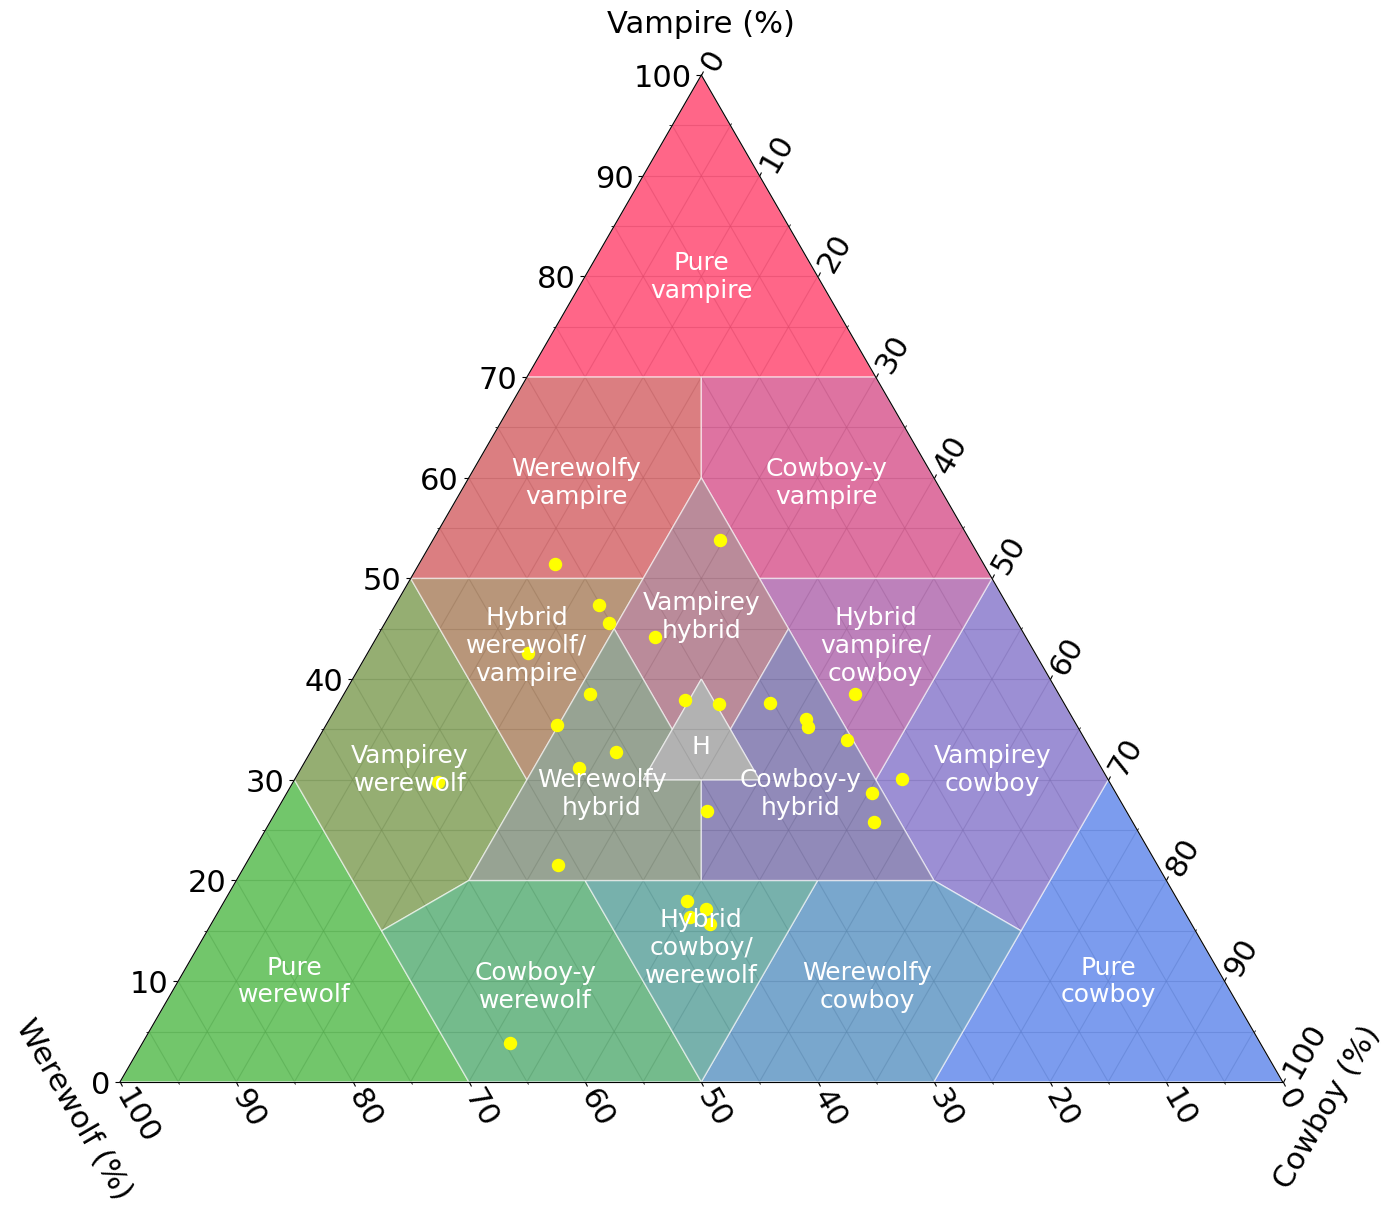

In [49]:
font = {'family': 'sans-serif',
        'size'   : 22, 
       'weight': 'normal'}

plt.rc('font', **font)

def calculate_centroid(vertices):
    roll0 = np.roll(vertices, 0, axis=0)
    roll1 = np.roll(vertices, 1, axis=0)
    cross = np.cross(roll0, roll1)
    area = 0.5 * np.sum(cross)
    return np.sum((roll0 + roll1) * cross[:, None], axis=0) / (6.0 * area) # centroid of the area for use in plotting annotations

def plot_personality_classes():
    fig = plt.figure(figsize=(15, 15), facecolor='white')
    ax = plt.subplot(projection="ternary", ternary_sum=100.0)
    ax.set_facecolor('white')                       
    
    for (key, value), color in zip(personality_classes.items(), section_colors):
        tn0, tn1, tn2 = np.array(value).T
        patch = ax.fill(tn0, tn1, tn2, ec="white", fc=color, alpha=0.6, zorder=2.1)
        centroid = calculate_centroid(patch[0].get_xy())
        label = key[::-1].replace(" ", "\n", 1)[::-1].capitalize()   # add line breaks at spaces
        label = label.replace('/', "/\n", 1)  # add line breaks at slashes

        ax.text(centroid[0],
                centroid[1],
                label,
                ha="center",
                va="center",
                color='white',
                fontweight='normal',
                transform=ax.transData,
                fontsize='18')
    
    ax.taxis.set_major_locator(MultipleLocator(10.0))
    ax.laxis.set_major_locator(MultipleLocator(10.0))
    ax.raxis.set_major_locator(MultipleLocator(10.0))
    ax.taxis.set_minor_locator(AutoMinorLocator(2))
    ax.laxis.set_minor_locator(AutoMinorLocator(2))
    ax.raxis.set_minor_locator(AutoMinorLocator(2))
    ax.grid(which="both", alpha=0.5)    
    ax.set_tlabel("Vampire (%)")
    ax.set_llabel("Werewolf (%)")
    ax.set_rlabel("Cowboy (%)")    
    ax.taxis.set_ticks_position("tick2")
    ax.laxis.set_ticks_position("tick2")
    ax.raxis.set_ticks_position("tick2")
    return ax, fig

def plot_personality_data(ax, df):
    ax.scatter(df['percent_vampire'],
               df['percent_werewolf'],
               df['percent_cowboy'],
               c='yellow',
               edgecolor='yellow',
               alpha=1,
               zorder=2.5,
               s=75, 
               label=df['Name'])

ax, fig = plot_personality_classes()  
plot_personality_data(ax, result_df_nonlinear) # plot point(s) on the graph
fig.savefig(os.path.join(project_fldr, 'vibe_triangle_redo.png'), transparent=False)

#result_output = os.path.join(project_fldr, 'results_csv_redo.csv')
#result_df_nonlinear[['Name', 'percent_vampire', 'percent_werewolf', 'percent_cowboy', 'class']].to_csv(result_output, index=False)